In [1]:
from pathlib import Path
import sys

ROOT = next((p for p in [Path.cwd(), *Path.cwd().parents] if (p / "scripts").is_dir() or (p / "data").is_dir()), None)
if ROOT is None:
    raise RuntimeError("Repo-Root not found (expected folder 'scripts' or 'data').")
sys.path.insert(0, str(ROOT))

DATA_DIR = ROOT / "data"
DRF_DIRS_BIG = [(DATA_DIR / "drf_big" / f"precomputed_drf_{m}", m) for m in ("edge", "vertex", "sp")]
DRF_DIRS_SMALL = [(DATA_DIR / "drf_small" / f"precomputed_drf_{m}", m) for m in ("edge", "vertex", "sp")]
ITS_DIRS_BIG = [(DATA_DIR / "its_big" / f"precomputed_its_{m}", m) for m in ("edge", "vertex", "sp")]
ITS_DIRS_SMALL = [(DATA_DIR / "its_small" / f"precomputed_its_{m}", m) for m in ("edge", "vertex", "sp")]

# WP3 — Kernel-based Classification (SVM)

This notebook implements kernel inner products on precomputed hashed feature sets and runs
SVM classification for DRF–WL and ITS–WL across different feature types (vertex/edge/shortest-path),
dataset sizes, numbers of classes, and train/test splits.

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
import pickle
from pathlib import Path
from collections import Counter

#local imports
from scripts.wp3.wp3_loader import (
    load_precomputed_features,
    available_subset_ids,
    load_precomputed_features_select
)

from scripts.wp3.wp3_kernel import (
    build_kernel_matrix_from_loaded, 
    kernel_matrix_stats,
    kernel_multiset_intersection,
    build_kernel_matrix_from_loaded, 
    kernel_matrix_stats,
)

from scripts.wp3.wp3_svm import (
    train_svm_from_precomputed_dir,
    #add_result,
    #_extract_accuracy,
)

from scripts.wp3.wp3_plots import (
    fig2_style_svm_from_kernel, 
    plot_bar_comparison,
    plot_experiment_dashboard,
    plot_heatmaps_by_k,
    plot_difference_heatmap,
    plot_slope_drf_vs_its,
    plot_bar_comparison,
    plot_drf_minus_its_bar,
    plot_drf_vs_its_dots,
    plot_accuracy_by_k,
)

from scripts.wp3.wp3_subset_handler import (
    make_option1_soft_shared_k_classes_config,
    print_option1_config,
    available_subset_ids,
    sanitize_subset_ids

)


## 1) Paths to precomputed feature directories

We load precomputed feature representations (stored as `.pkl`) for:
- DRF–WL: reactant/product difference features
- ITS–WL: features from the ITS reaction graph

Each representation is available for three feature modes: vertex, edge, shortest-path.

### Load DRF–WL Features
Load precomputed DRF–WL feature sets and reaction class labels for kernel-based classification.

In [3]:

X_drf, y_drf = {}, {}
for path, mode in DRF_DIRS_BIG:  # ACHTUNG: Reihenfolge (path, mode)
    assert path.exists(), f"Pfad nicht gefunden: {path}"
    X, y = load_precomputed_features(path, feature_key="drf_wl")
    X_drf[mode] = X
    y_drf[mode] = y
    print(f"\nLoaded DRF features ({mode}) from {path}")
    print("Number of reactions:", len(X))
    print("Number of classes:", len(set(y)))


Loaded DRF features (edge) from /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/drf_big/precomputed_drf_edge
Number of reactions: 50000
Number of classes: 50

Loaded DRF features (vertex) from /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/drf_big/precomputed_drf_vertex
Number of reactions: 50000
Number of classes: 50

Loaded DRF features (sp) from /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/drf_big/precomputed_drf_sp
Number of reactions: 50000
Number of classes: 50


### Load ITS–WL Features
Load precomputed ITS–WL feature sets and reaction class labels derived from the ITS graph.

In [4]:
X_its = {}
y_its = {}
for path, mode in ITS_DIRS_BIG:  # ACHTUNG: Reihenfolge (path, mode)
    assert path.exists(), f"Pfad nicht gefunden: {path}"
    X, y = load_precomputed_features(path, feature_key="its_wl")
    X_its[mode] = X
    y_its[mode] = y
    print(f"\nLoaded ITS features ({mode}) from {path}")
    print("Number of reactions:", len(X))
    print("Number of classes:", len(set(y)))



Loaded ITS features (edge) from /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/its_big/precomputed_its_edge
Number of reactions: 50000
Number of classes: 50

Loaded ITS features (vertex) from /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/its_big/precomputed_its_vertex
Number of reactions: 50000
Number of classes: 50

Loaded ITS features (sp) from /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/its_big/precomputed_its_sp
Number of reactions: 50000
Number of classes: 50


The output confirms that all precomputed DRF–WL feature representations
(edge, vertex, and shortest-path) were loaded successfully. Each representation
contains the full dataset of 50,000 reactions across 50 reaction classes,
providing a consistent basis for kernel computation and classification.

## 2) Kernel inner product on hash sets

The lab definition reduces all kernels to counting common elements of two hashed feature sets.
Given two reactions with feature hash sets \(S_G, S_H\), the kernel is:
\[
k(G,H) = |S_G \cap S_H|
\]

Our precomputed features are stored as Counters. For the required hashset kernel, we use the Counter keys.

Ein Kernel ist eine Funktion, die sagt, wie ähnlich zwei Reaktionen sind.

### Kernel sanity check (DRF–WL)

We verify that the multiset kernel produces meaningful similarities on the precomputed DRF–WL feature multisets.  
Self-similarity \(k(x,x)\) is clearly positive, and different reactions can still share a non-zero overlap, indicating common reaction-change patterns captured by DRF–WL.

In [5]:
mode = "edge"   # "edge" | "vertex" | "sp"
X = X_its[mode]  # oder X_drf[mode]

# finde erstes Paar mit k>0
for i in range(len(X)):
    if len(X[i]) == 0:
        continue
    for j in range(i + 1, len(X)):
        if len(X[j]) == 0:
            continue
        k = kernel_multiset_intersection(X[i], X[j])
        if k > 0:
            print("Found non-zero kernel at:", i, j, "value:", k)
            break
    else:
        continue
    break


Found non-zero kernel at: 0 1 value: 6


In [6]:
# Finde ein nicht-leeres Paar
for i in range(len(X)):
    if len(X[i]) == 0:
        continue
    for j in range(i+1, len(X)):
        if len(X[j]) == 0:
            continue
        k = kernel_multiset_intersection(X[i], X[j])
        if k > 0:
            print("Found non-zero kernel at:", i, j, "value:", k)
            break
    else:
        continue
    break

Found non-zero kernel at: 0 1 value: 6


### Kernel Matrix Construction

To apply kernel-based classification, the pairwise similarities between all reactions are computed and stored in a kernel matrix. Each entry \(K_{ij}\) represents the multiset kernel value between reactions \(i\) and \(j\). This matrix serves as the direct input for training a Support Vector Machine with a precomputed kernel.

### DRF–WL Kernel Matrix (edge features)

This heatmap visualizes the kernel matrix computed using the DRF–WL edge kernel for a subset of reactions.
Each entry \(K_{ij}\) represents the multiset intersection between the DRF–WL feature representations of reaction \(i\) and reaction \(j\).

The bright diagonal indicates high self-similarity, as each reaction shares all its features with itself.
Most off-diagonal entries are close to zero, which reflects the sparsity of the DRF representation:  
DRF removes all static molecular structure and retains only features corresponding to reaction-specific changes.

Non-zero off-diagonal values highlight pairs of reactions that share similar bond-change patterns.
This confirms that the DRF–WL kernel captures meaningful similarities between reactions while remaining highly selective.

In [7]:
mode = "edge"   # "edge" | "vertex" | "sp"
n = 200

K_drf, y_small = build_kernel_matrix_from_loaded(
    X_drf, y_drf,
    mode=mode,
    n=n,
)

stats = kernel_matrix_stats(K_drf)
print("Kernel matrix stats:", stats)

fig = px.imshow(
    K_drf,
    title=f"Kernel Matrix Heatmap (DRF–WL {mode}, n={n})",
    aspect="auto",
)
fig.show()

Kernel matrix stats: {'n': 200.0, 'sym_max_abs': 0.0, 'diag_min': 0.0, 'diag_max': 110.0, 'nonzero_share': 0.24645, 'median': 0.0, 'mean': 1.0637999773025513, 'max': 110.0}


**Figure (DRF–WL):** Kernel matrix heatmap computed using the DRF–WL edge kernel.
Each entry \(K_{ij}\) represents the multiset intersection between the DRF–WL feature representations of reactions \(i\) and \(j\).
The diagonal indicates self-similarity, while off-diagonal values are mostly close to zero.
This sparsity reflects the DRF representation, which removes static molecular structure and retains only reaction-specific changes.
Non-zero off-diagonal entries therefore highlight reactions with similar bond-change patterns.

#### Error Handling

In [8]:
path = DATA_DIR / "drf_small/precomputed_drf_edge"
pkl = next(path.glob("*.pkl"))   # ← HIER ist next() richtig
obj = pickle.load(open(pkl, "rb"))

print("Keys:", obj.keys())
print("n_errors:", obj["meta"]["n_errors"])
print("First error:", obj["errors"][:1])
print("First feature:", type(obj["drf_wl"][0]), obj["drf_wl"][0])

Keys: dict_keys(['meta', 'rsmi', 'classes', 'drf_wl', 'errors'])
n_errors: 0
First error: []
First feature: <class 'collections.Counter'> Counter({'a82838b20364425c67fcb5c7e9afe41e': 2, '5450379d4b597bf1c7af1a3c9f693e38': 2, '144e500ccedd25f71f204f17362141d5': 2, '6d313c7f7232721ae18a5bca00bc11ef': 2, 'e18af7080f8f530277220e4e452e4eda': 2, 'c6764b9ca50efd6d3e9fb6f852bc2f0e': 2, '602bd8e20c9c046a4919fa6bd48fa7d4': 1, '3c96fdc9d330460f21aeb28e07575879': 1, '547f58cf21f27c8b82bd711df1b44914': 1, '2454d79cc5ad08b5839b2412010649de': 1, 'b8fb27b68fdd36b9df573dae55ce06d1': 1, '10d1f4a56deacec06e10f22777ebabf7': 1, '6aef668f83375a3f29b8d61aaa609776': 1, 'd32b7afca00a4807e01bb9945ccf1495': 1, 'de29cd00dc3c165e4e4fe0b3a05bb6a7': 1, '7f4568e0d5321cd5e4f18b42c3851107': 1, 'b63332285bf4357676d3672defc787c5': 1, '01eb2445818b1fa0a2dbaa8579c50538': 1, '5f0938fcffb698773cb194e4f3638bfb': 1, '38e9567c8f82ea78b720f222ad4bf422': 1, '50209bf1b330abeccd7cddf1e7f41d32': 1, '479115f6cfb42efa19c231560b67f58e'

In [9]:

DIR = DATA_DIR / "drf_small/precomputed_drf_edge"  # <- GENAU der Ordner, den du lädst
pkl = sorted(DIR.glob("*.pkl"))[0]
print("Inspecting:", pkl)

with open(pkl, "rb") as f:
    obj = pickle.load(f)

print("Keys:", obj.keys())
print("Meta n_rows:", obj["meta"]["n_rows"])
print("Meta n_errors:", obj["meta"]["n_errors"])
print("First error (if any):", obj["errors"][:1])

# Jetzt das wichtigste:
X = obj["drf_wl"]
empty = sum(1 for c in X if len(c) == 0)
print("Empty counters:", empty, "/", len(X))

# Beispiel suchen
for i, c in enumerate(X):
    if len(c) > 0:
        print("First non-empty at idx:", i, "items:", len(c), "total:", sum(c.values()))
        print("Sample:", list(c.items())[:5])
        break
else:
    print("ALL COUNTERS ARE EMPTY in this PKL.")


Inspecting: /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/drf_small/precomputed_drf_edge/subset_001.reaction_features_drf_wl_h3_edge.pkl
Keys: dict_keys(['meta', 'rsmi', 'classes', 'drf_wl', 'errors'])
Meta n_rows: 60
Meta n_errors: 0
First error (if any): []
Empty counters: 0 / 60
First non-empty at idx: 0 items: 52 total: 54
Sample: [('86673f02a9bba3113b35f611fee08fab', 1), ('9b809fa431672ccefbfe5b6d0402de51', 2), ('ba69450099be1228e55119b644917475', 2), ('e11f3902c40931c8135357648e383a14', 1), ('dbacacd83403b2a6183294a013ec6171', 1)]


In [10]:
pkls = list(path.glob("*.pkl"))
print("Found PKLs:", len(pkls))

pkl = pkls[0]
obj = pickle.load(open(pkl, "rb"))

print("n_errors:", obj["meta"]["n_errors"])
print("empty:", sum(1 for c in obj["drf_wl"] if len(c)==0), "/", len(obj["drf_wl"]))
print("example total count:", sum(obj["drf_wl"][0].values()))

Found PKLs: 834
n_errors: 0
empty: 0 / 60
example total count: 52


### ITS–WL Kernel Matrix (edge features)

This heatmap shows the kernel matrix computed using the ITS–WL edge kernel.
Here, reactions are represented by Weisfeiler–Lehman features extracted from the Imaginary Transition State (ITS) graph.

Compared to DRF–WL, the ITS–WL kernel produces a denser similarity structure.
This is expected, as the ITS graph encodes the full combined structure of reactants and products, including unchanged molecular context.

The diagonal again represents self-similarity, while the richer off-diagonal structure indicates that many reactions share common substructures.
As a result, ITS–WL captures broader structural similarity between reactions, not only the explicit reaction center.

In [11]:
mode = "edge"
n = 200

K_its, y_its_small = build_kernel_matrix_from_loaded(
    X_its, y_its,
    mode=mode,
    n=n,
)

print("ITS kernel matrix stats:", kernel_matrix_stats(K_its))

fig = px.imshow(
    K_its,
    title=f"Kernel Matrix Heatmap (ITS–WL {mode}, n={n})",
    aspect="auto",
)
fig.show()

ITS kernel matrix stats: {'n': 200.0, 'sym_max_abs': 0.0, 'diag_min': 36.0, 'diag_max': 220.0, 'nonzero_share': 0.9792, 'median': 11.0, 'mean': 12.855999946594238, 'max': 220.0}


**Figure (ITS–WL):** Kernel matrix heatmap computed using the ITS–WL edge kernel.
Each entry \(K_{ij}\) corresponds to the multiset intersection of Weisfeiler–Lehman features extracted from the Imaginary Transition State graphs.
Compared to DRF–WL, the ITS–WL kernel exhibits a denser similarity structure, as the ITS graph encodes the full molecular context of reactants and products.
Off-diagonal similarities reflect shared structural motifs beyond the reaction center.

### Comparison of DRF–WL and ITS–WL Kernel Matrices

The DRF–WL and ITS–WL kernel matrices reveal complementary notions of reaction similarity.
DRF–WL focuses exclusively on reaction-specific changes by computing the symmetric difference between reactant and product features.
As a result, the corresponding kernel matrix is sparse, with non-zero similarities only for reactions that share similar bond-change patterns.

In contrast, ITS–WL operates on the Imaginary Transition State graph, which encodes the full structural context of both reactants and products.
This leads to a denser kernel matrix, as reactions may share common substructures even if their reaction centers differ.

Consequently, DRF–WL provides a highly selective notion of similarity tailored to reaction mechanisms,
whereas ITS–WL captures broader structural resemblance between reactions.
Both representations are therefore suitable for different aspects of reaction classification.

**Figure:** Kernel matrix heatmaps for DRF–WL (bottom) and ITS–WL (top) using edge-based Weisfeiler–Lehman features.
Each entry \(K_{ij}\) corresponds to the multiset intersection between the feature representations of reactions \(i\) and \(j\).
The diagonal indicates self-similarity, while off-diagonal values reflect shared structural or reaction-specific features.
DRF–WL produces a sparse kernel emphasizing reaction changes, whereas ITS–WL yields a denser kernel capturing overall structural similarity.

In [12]:

def upper_triangle_values(K):
    n = K.shape[0]
    return K[np.triu_indices(n, k=1)]

vals_drf = upper_triangle_values(K_drf)  # DRF Kernel-Matrix
vals_its = upper_triangle_values(K_its)  # ITS Kernel-Matrix

fig = px.histogram(
    x=[vals_drf, vals_its],
    labels={"value": "Kernel value", "variable": "Kernel"},
    nbins=50,
    opacity=0.6,
    title="Distribution of Kernel Values: DRF–WL vs ITS–WL",
)

fig.data[0].name = "DRF–WL"
fig.data[1].name = "ITS–WL"
fig.show()

**Figure:** Distribution of off-diagonal kernel values for DRF–WL and ITS–WL.
DRF–WL produces a highly sparse similarity distribution with many zero entries, reflecting its focus on reaction-specific changes.
In contrast, ITS–WL yields a broader distribution, capturing shared structural context between reactions.

## SVM Classification with a Custom Reaction Kernel

An SVM classifier was trained using a custom kernel based on the multiset intersection of reaction features.
Since the kernel operates on pairs of reactions rather than explicit feature vectors, the kernel matrix was precomputed and passed to the SVM using `kernel="precomputed"`.
All classification experiments are conducted using precomputed kernel feature representations.
This enables a fair comparison between DRF–WL and ITS–WL kernels, as the same SVM configuration
and training procedure is applied to both representations.


To systematically evaluate kernel variants, we run the same SVM setup for each feature mode separately.
This yields comparable accuracies for edge-, vertex-, and shortest-path-based WL representations without mixing feature spaces.

### 0) Subsets vorbereiten nach passenden Klassen


#### Results speichern

In [13]:
from pathlib import Path
import sys

# Repo-Root robust finden (da wo "data" oder "scripts" liegt)
ROOT = next(
    (p for p in [Path.cwd(), *Path.cwd().parents]
     if (p / "data").is_dir() or (p / "scripts").is_dir()),
    None
)
if ROOT is None:
    raise RuntimeError("Repo-Root not found (expected folder 'data' or 'scripts').")

DATA_DIR = ROOT / "data"
print("ROOT:", ROOT)
print("DATA_DIR:", DATA_DIR)

# Precompute-Ordner  (small version)
DRF_DIRS = {
    "edge":   DATA_DIR / "drf_small" / "precomputed_drf_edge",
    "vertex": DATA_DIR / "drf_small" / "precomputed_drf_vertex",
    "sp":     DATA_DIR / "drf_small" / "precomputed_drf_sp",
}
ITS_DIRS = {
    "edge":   DATA_DIR / "its_small" / "precomputed_its_edge",
    "vertex": DATA_DIR / "its_small" / "precomputed_its_vertex",
    "sp":     DATA_DIR / "its_small" / "precomputed_its_sp",
}

for k,v in DRF_DIRS.items():
    print("DRF", k, "->", v)
for k,v in ITS_DIRS.items():
    print("ITS", k, "->", v)

ROOT: /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels
DATA_DIR: /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data
DRF edge -> /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/drf_small/precomputed_drf_edge
DRF vertex -> /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/drf_small/precomputed_drf_vertex
DRF sp -> /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/drf_small/precomputed_drf_sp
ITS edge -> /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/its_small/precomputed_its_edge
ITS vertex -> /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/its_small/precomputed_its_vertex
ITS sp -> /Users/patriciabombik/Workspaces/Uni_Master_Projekte/reaction-kernels/data/its_small/precomputed_its_sp


In [14]:
# --- overwrite add_result robustly (accepts res.acc OR res.accuracy OR dict) ---

results = []  # keep or remove; only if you want to reset

def _extract_accuracy(res):
    # dict
    if isinstance(res, dict):
        for k in ("accuracy", "acc", "score"):
            if k in res and res[k] is not None:
                return float(res[k])
        if "metrics" in res and isinstance(res["metrics"], dict):
            for k in ("accuracy", "acc", "score"):
                if k in res["metrics"] and res["metrics"][k] is not None:
                    return float(res["metrics"][k])

    # object: YOUR CASE (SVMResult has .acc)
    for attr in ("accuracy", "acc", "score"):
        if hasattr(res, attr):
            val = getattr(res, attr)
            if val is not None:
                return float(val)

    # fallback: __dict__
    if hasattr(res, "__dict__"):
        d = res.__dict__
        for k in ("accuracy", "acc", "score"):
            if k in d and d[k] is not None:
                return float(d[k])

    raise ValueError(f"Could not extract accuracy from res. type={type(res)} attrs={dir(res)}")

results = []

def add_result(tag, kernel, mode, n, test_size, C, seed, res, subset_ids=None, k=None, **extra):
    # accuracy robust holen (SVMResult hat .acc)
    if isinstance(res, dict):
        acc = res.get("accuracy", None)
    else:
        acc = getattr(res, "accuracy", None)
        if acc is None:
            acc = getattr(res, "acc", None)

    if acc is None:
        raise ValueError("Could not extract accuracy from res (need dict['accuracy'] or .accuracy/.acc).")

    results.append({
        "tag": tag,
        "kernel": kernel,      # "DRF–WL" oder "ITS–WL"
        "mode": mode,          # "edge"/"vertex"/"sp"
        "n": int(n),
        "test_size": float(test_size),
        "C": float(C),
        "seed": int(seed),
        "accuracy": float(acc),
        "subset_ids": list(subset_ids) if subset_ids is not None else None,
        "k": int(k) if k is not None else None,
        **extra,
    })

In [15]:
def sanitize_subset_ids(precomp_dir, subset_ids):
    avail = set(available_subset_ids(precomp_dir))
    cleaned = [sid for sid in subset_ids if sid in avail]
    missing = [sid for sid in subset_ids if sid not in avail]
    if missing:
        print(f"[WARN] Missing subset ids in {precomp_dir}: {missing}")
    if not cleaned:
        raise ValueError(f"After sanitizing, subset_ids is empty. Available ids: {sorted(avail)[:50]} ...")
    return cleaned

def safe_subset_ids(option_subset_ids, drf_dir, its_dir, take=20):
    option_subset_ids = list(option_subset_ids) if option_subset_ids else []
    if len(option_subset_ids) > 0:
        return option_subset_ids

    # fallback: nimm einfach gemeinsame subset ids
    common = sorted(set(available_subset_ids(drf_dir)) & set(available_subset_ids(its_dir)))
    if not common:
        raise FileNotFoundError("No common subset_*.pkl between DRF and ITS dirs.")
    return common[:take]

In [16]:
def count_pkls(p: Path) -> int:
    return len(list(p.glob("*.pkl")))

print("\n--- PKL counts ---")
for mode, p in DRF_DIRS.items():
    print("DRF", mode, ":", count_pkls(p))
for mode, p in ITS_DIRS.items():
    print("ITS", mode, ":", count_pkls(p))


--- PKL counts ---
DRF edge : 834
DRF vertex : 834
DRF sp : 834
ITS edge : 834
ITS vertex : 834
ITS sp : 834


In [17]:
import pandas as pd

# =========================
# Global experiment settings
# =========================
C = 1.0
seed = 42
test_sizes = [0.2]        # baseline
n_values = [600]          # baseline

# -------------------------------------------------------
# Option 1: Wähle subset_ids so, dass DRF & ITS vergleichbar sind
# (OHNE danach Klassen hart zu filtern)
# -------------------------------------------------------
opt1 = make_option1_soft_shared_k_classes_config(
    drf_edge_dir=DRF_DIRS["edge"],
    its_edge_dir=ITS_DIRS["edge"],
    k=2,
    take_subsets=20,
    min_per_class=10,
    ref_scan=50,
)

subset_ids = opt1["subset_ids"]

print("Option 1 config:")
print(opt1)
print("Chosen subset_ids:", subset_ids)
print("Number of chosen subsets:", len(subset_ids))


# Option 1B: k gemeinsame Klassen erzwingen (soft/realistisch)
opt1b = make_option1_soft_shared_k_classes_config(
    drf_edge_dir=DRF_DIRS["edge"],
    its_edge_dir=ITS_DIRS["edge"],
    k=2,
    take_subsets=20,
    min_per_class=10,
    ref_scan=50,
    ref_side="its",
)
print_option1_config(opt1b)

subset_ids = opt1b["subset_ids"]
allowed_classes = opt1b["target_classes"]   # optional: fürs Filtern im Training

Option 1 config:
{'name': 'opt1_soft_shared_k2_min10_refScan50_its', 'subset_ids': [10, 787], 'target_classes': ['3.4.1', '6.3.7'], 'k': 2, 'min_per_class': 10, 'ref_scan': 50, 'ref_side': 'its', 'n_common_available': 834}
Chosen subset_ids: [10, 787]
Number of chosen subsets: 2
Option1 config: opt1_soft_shared_k2_min10_refScan50_its
subset_ids (first 20): [10, 787]
n_subsets: 2
target_classes: ['3.4.1', '6.3.7']


### 1) Baseline Comparison: DRF–WL vs ITS–WL

In this experiment, DRF–WL and ITS–WL kernels are compared under identical conditions to provide a fair baseline.
All parameters are fixed (feature mode, dataset size, train/test split, and SVM regularization), and only the
graph representation differs. This allows us to directly assess the impact of reaction-based versus structure-based
graph representations on classification performance.

In [18]:
# =========================
# Section 4: Baseline (k=1 vs k=2)
# =========================
# Wichtig: DATA_DIR, DRF_DIRS, ITS_DIRS musst du vorher definiert haben.
# results sammelt alle Runs

for k in [1, 2]:
    opt1 = make_option1_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS["edge"],
        its_edge_dir=ITS_DIRS["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )
    subset_ids = safe_subset_ids(opt1["subset_ids"], DRF_DIRS["edge"], ITS_DIRS["edge"], take=20)

    print(f"\n[S4 | k={k}] using {len(subset_ids)} subsets:", subset_ids[:10], "..." if len(subset_ids)>10 else "")

    # DRF edge
    res = train_svm_from_precomputed_dir(
        precomp_dir=DRF_DIRS["edge"],
        feature_key="drf_wl",
        subset_ids=subset_ids,
        n=600, test_size=0.2, C=C, seed=seed,
        verbose=False,
    )
    add_result("S4_baseline", "DRF–WL", "edge", 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

    # ITS edge
    res = train_svm_from_precomputed_dir(
        precomp_dir=ITS_DIRS["edge"],
        feature_key="its_wl",
        subset_ids=subset_ids,
        n=600, test_size=0.2, C=C, seed=seed,
        verbose=False,
    )
    add_result("S4_baseline", "ITS–WL", "edge", 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

df_results = pd.DataFrame(results)
df_results[df_results["tag"]=="S4_baseline"][["kernel","mode","k","n","test_size","accuracy","subset_ids"]].sort_values(["k","kernel"])


[S4 | k=1] using 30 subsets: [1, 10, 13, 37, 42, 44, 55, 64, 70, 80] ...

[S4 | k=2] using 20 subsets: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ...


,kernel,mode,k,n,test_size,accuracy,subset_ids
0,DRF–WL,edge,1,600,0.2,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
1,ITS–WL,edge,1,600,0.2,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
2,DRF–WL,edge,2,600,0.2,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,ITS–WL,edge,2,600,0.2,0.600000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### 2) Feature Mode Comparison

This section evaluates the influence of different feature extraction modes on classification accuracy.
Edge-, vertex-, and shortest-path-based WL features are compared while keeping all other parameters fixed.
The experiment highlights which structural information is most informative for reaction classification.

In [19]:
# =========================
# Section 5: Modes (edge/vertex/sp)
# =========================

C = 1.0
seed = 42
test_size = 0.2
n = 600

for k in [1, 2]:
    opt1 = make_option1_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS["edge"],
        its_edge_dir=ITS_DIRS["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )
    subset_ids = safe_subset_ids(opt1["subset_ids"], DRF_DIRS["edge"], ITS_DIRS["edge"], take=20)

    print(f"\n[S5 | k={k}] using {len(subset_ids)} subsets")

    for mode in ["edge", "vertex", "sp"]:
        # DRF
        res = train_svm_from_precomputed_dir(
            precomp_dir=DRF_DIRS[mode],
            feature_key="drf_wl",
            subset_ids=subset_ids,
            n=600, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        add_result("S5_modes", "DRF–WL", mode, 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

        # ITS
        res = train_svm_from_precomputed_dir(
            precomp_dir=ITS_DIRS[mode],
            feature_key="its_wl",
            subset_ids=subset_ids,
            n=600, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        add_result("S5_modes", "ITS–WL", mode, 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

df_results = pd.DataFrame(results)
df_results[df_results["tag"]=="S5_modes"][["kernel","mode","k","n","accuracy","subset_ids"]].sort_values(["k","kernel","mode"])


[S5 | k=1] using 30 subsets

[S5 | k=2] using 20 subsets


,kernel,mode,k,n,accuracy,subset_ids
4,DRF–WL,edge,1,600,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
8,DRF–WL,sp,1,600,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
6,DRF–WL,vertex,1,600,0.850000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
5,ITS–WL,edge,1,600,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
9,ITS–WL,sp,1,600,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
7,ITS–WL,vertex,1,600,0.616667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
10,DRF–WL,edge,2,600,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
14,DRF–WL,sp,2,600,0.450000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
12,DRF–WL,vertex,2,600,0.850000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
11,ITS–WL,edge,2,600,0.600000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### 3) Effect of Dataset Size

To study the scalability and robustness of the kernel-based approach, the dataset size is varied while
keeping the kernel configuration constant. This experiment shows how classification performance changes
as more training data becomes available.

In [20]:
# =========================
# Section 6: Size sweep (n)
# =========================

C = 1.0
seed = 42
test_size = 0.2

# WICHTIG: alle Subsets verwenden
subset_ids = None   # <-- DAS ist der richtige Ort

print("\n[Section 6] Using ALL subsets (subset_ids=None)")

for k in [1, 2]:
    opt1 = make_option1_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS["edge"],
        its_edge_dir=ITS_DIRS["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )
    subset_ids = safe_subset_ids(opt1["subset_ids"], DRF_DIRS["edge"], ITS_DIRS["edge"], take=20)

    print(f"\n[S6 | k={k}] using {len(subset_ids)} subsets")

    for n in [200, 600, 1200]:
        # DRF edge
        res = train_svm_from_precomputed_dir(
            precomp_dir=DRF_DIRS["edge"],
            feature_key="drf_wl",
            subset_ids=subset_ids,
            n=n, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        add_result("S6_size", "DRF–WL", "edge", n, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

        # ITS edge
        res = train_svm_from_precomputed_dir(
            precomp_dir=ITS_DIRS["edge"],
            feature_key="its_wl",
            subset_ids=subset_ids,
            n=n, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        add_result("S6_size", "ITS–WL", "edge", n, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

# Ergebnisse anzeigen
df_results = pd.DataFrame(results)
df_results[df_results["tag"]=="S6_size"][
    ["kernel", "mode", "n", "accuracy"]
].sort_values(["kernel", "n"])


[Section 6] Using ALL subsets (subset_ids=None)

[S6 | k=1] using 30 subsets

[S6 | k=2] using 20 subsets


,kernel,mode,n,accuracy
16,DRF–WL,edge,200,0.850000
22,DRF–WL,edge,200,0.725000
18,DRF–WL,edge,600,0.750000
24,DRF–WL,edge,600,0.808333
20,DRF–WL,edge,1200,0.762500
26,DRF–WL,edge,1200,0.804167
17,ITS–WL,edge,200,0.675000
23,ITS–WL,edge,200,0.625000
19,ITS–WL,edge,600,0.566667
25,ITS–WL,edge,600,0.600000


### 4) Effect of Train/Test Split

This experiment investigates the sensitivity of the SVM classifier to different train/test splits.
By increasing the proportion of test data, we assess the stability and generalization capability of the
kernel-based model.

In [21]:
# Settings
C = 1.0
seed = 42
n = 600

for k in [1, 2]:
    opt1 = make_option1_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS["edge"],
        its_edge_dir=ITS_DIRS["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )

    subset_ids = safe_subset_ids(opt1["subset_ids"], DRF_DIRS["edge"], ITS_DIRS["edge"], take=20)
    print(f"\n[S7 | k={k}] using {len(subset_ids)} subsets:", subset_ids[:10], "..." if len(subset_ids)>10 else "")

    for ts in [0.1, 0.2, 0.3, 0.4]:
        # DRF edge
        res = train_svm_from_precomputed_dir(
            precomp_dir=DRF_DIRS["edge"],
            feature_key="drf_wl",
            subset_ids=subset_ids,
            n=n, test_size=ts, C=C, seed=seed,
            verbose=False,
        )
        add_result("S7_split", "DRF–WL", "edge", n, ts, C, seed, res, subset_ids=subset_ids, k=k)

        # ITS edge
        res = train_svm_from_precomputed_dir(
            precomp_dir=ITS_DIRS["edge"],
            feature_key="its_wl",
            subset_ids=subset_ids,
            n=n, test_size=ts, C=C, seed=seed,
            verbose=False,
        )
        add_result("S7_split", "ITS–WL", "edge", n, ts, C, seed, res, subset_ids=subset_ids, k=k)

df_results = pd.DataFrame(results)

# Section 7 anzeigen (nicht S4!)
df_results[df_results["tag"]=="S7_split"][["kernel","k","mode","n","test_size","accuracy","subset_ids"]].sort_values(["k","kernel","test_size"])


[S7 | k=1] using 30 subsets: [1, 10, 13, 37, 42, 44, 55, 64, 70, 80] ...

[S7 | k=2] using 20 subsets: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ...


,kernel,k,mode,n,test_size,accuracy,subset_ids
28,DRF–WL,1,edge,600,0.1,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
30,DRF–WL,1,edge,600,0.2,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
32,DRF–WL,1,edge,600,0.3,0.761111,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
34,DRF–WL,1,edge,600,0.4,0.741667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
29,ITS–WL,1,edge,600,0.1,0.583333,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
31,ITS–WL,1,edge,600,0.2,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
33,ITS–WL,1,edge,600,0.3,0.572222,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
35,ITS–WL,1,edge,600,0.4,0.550000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
36,DRF–WL,2,edge,600,0.1,0.783333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
38,DRF–WL,2,edge,600,0.2,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### 2) Feature Mode Comparison

This section evaluates the influence of different feature extraction modes on classification accuracy.
Edge-, vertex-, and shortest-path-based WL features are compared while keeping all other parameters fixed.
The experiment highlights which structural information is most informative for reaction classification.

In [22]:
tag = "S5_modes"
n = 600
test_size = 0.2

for mode in ["vertex","edge","sp"]:
    # DRF
    res = train_svm_from_precomputed_dir(
        precomp_dir=DRF_DIRS[mode], feature_key="drf_wl",
        subset_ids=subset_ids, n=n, test_size=test_size, C=C, seed=seed,
        verbose=False,
    )
    add_result(
    tag="S5_modes",
    kernel="DRF–WL",
    mode=mode,
    n=n,
    test_size=test_size,
    C=C,
    seed=seed,
    res=res,
    subset_ids=subset_ids,
    k=k
)
    # ITS
    res = train_svm_from_precomputed_dir(
        precomp_dir=ITS_DIRS[mode], feature_key="its_wl",
        subset_ids=subset_ids, n=n, test_size=test_size, C=C, seed=seed,
        verbose=False,
    )
    add_result(
    tag="S5_modes",
    kernel="ITS–WL",
    mode=mode,
    n=n,
    test_size=test_size,
    C=C,
    seed=seed,
    res=res,
    subset_ids=subset_ids,
    k=k
)

df_results = pd.DataFrame(results)
df_results[df_results["tag"]==tag][["kernel","mode","n","test_size","accuracy","subset_ids"]].sort_values(["kernel","mode"])

,kernel,mode,n,test_size,accuracy,subset_ids
4,DRF–WL,edge,600,0.2,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
10,DRF–WL,edge,600,0.2,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
46,DRF–WL,edge,600,0.2,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
8,DRF–WL,sp,600,0.2,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
14,DRF–WL,sp,600,0.2,0.450000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
48,DRF–WL,sp,600,0.2,0.450000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
6,DRF–WL,vertex,600,0.2,0.850000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
12,DRF–WL,vertex,600,0.2,0.850000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
44,DRF–WL,vertex,600,0.2,0.850000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
5,ITS–WL,edge,600,0.2,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."


### 3) Effect of Dataset Size

To study the scalability and robustness of the kernel-based approach, the dataset size is varied while
keeping the kernel configuration constant. This experiment shows how classification performance changes
as more training data becomes available.

In [23]:
# =========================
# Section 7: Split sweep (test_size)
# =========================

for n in [200, 600, 1200]:
    res = train_svm_from_precomputed_dir(
        precomp_dir=DRF_DIRS["edge"], feature_key="drf_wl",
        subset_ids=subset_ids, n=n, test_size=test_size, C=C, seed=seed,
        verbose=False,
    )
    add_result(
    tag="S6_size",
    kernel="DRF–WL",
    mode="edge",
    n=n,
    test_size=test_size,
    C=C,
    seed=seed,
    res=res,
    subset_ids=subset_ids,
    k=k
    )

    res = train_svm_from_precomputed_dir(
        precomp_dir=ITS_DIRS["edge"], feature_key="its_wl",
        subset_ids=subset_ids, n=n, test_size=test_size, C=C, seed=seed,
        verbose=False,
    )
    add_result(
    tag="S6_size",
    kernel="ITS–WL",
    mode="edge",
    n=n,
    test_size=test_size,
    C=C,
    seed=seed,
    res=res,
    subset_ids=subset_ids,
    k=k
    )

df_results = pd.DataFrame(results)
df_results[df_results["tag"]==tag][["kernel","n","accuracy","subset_ids"]].sort_values(["kernel","n"])

,kernel,n,accuracy,subset_ids
4,DRF–WL,600,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
6,DRF–WL,600,0.850000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
8,DRF–WL,600,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
10,DRF–WL,600,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
12,DRF–WL,600,0.850000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
14,DRF–WL,600,0.450000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
44,DRF–WL,600,0.850000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
46,DRF–WL,600,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
48,DRF–WL,600,0.450000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
5,ITS–WL,600,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."


### 4) Effect of Train/Test Split

This experiment investigates the sensitivity of the SVM classifier to different train/test splits.
By increasing the proportion of test data, we assess the stability and generalization capability of the
kernel-based model.

In [24]:
tag = "S7_splits"
n = 600

# WICHTIG: alle Subsets verwenden
subset_ids = None   # <-- NICHT [] !!!

print("\n[Section 7] Using ALL subsets (subset_ids=None)")

for test_size in [0.1, 0.2, 0.3, 0.4]:
    print(f"\n[S7] test_size = {test_size}")

    # DRF–WL edge
    res = train_svm_from_precomputed_dir(
        precomp_dir=DRF_DIRS["edge"],
        feature_key="drf_wl",
        subset_ids=subset_ids,   # None = alle PKLs
        n=n,
        test_size=test_size,
        C=C,
        seed=seed,
        verbose=False,
    )
    add_result(
        tag="S7_split",
        kernel="DRF–WL",
        mode="edge",
        n=n,
        test_size=test_size,
        C=C,
        seed=seed,
        res=res,
        subset_ids=subset_ids,
        k=k
    )

    # ITS–WL edge
    res = train_svm_from_precomputed_dir(
        precomp_dir=ITS_DIRS["edge"],
        feature_key="its_wl",
        subset_ids=subset_ids,   # None = alle PKLs
        n=n,
        test_size=test_size,
        C=C,
        seed=seed,
        verbose=False,
    )
    add_result(
        tag="S7_split",
        kernel="ITS–WL",
        mode="edge",
        n=n,
        test_size=test_size,
        C=C,
        seed=seed,
        res=res,
        subset_ids=subset_ids,
        k=k
    )

df_results = pd.DataFrame(results)
df_results[df_results["tag"]=="S7_split"][["kernel","mode","n","test_size","accuracy"]].sort_values(["kernel","test_size"])


[Section 7] Using ALL subsets (subset_ids=None)

[S7] test_size = 0.1

[S7] test_size = 0.2

[S7] test_size = 0.3

[S7] test_size = 0.4


,kernel,mode,n,test_size,accuracy
28,DRF–WL,edge,600,0.1,0.750000
36,DRF–WL,edge,600,0.1,0.783333
56,DRF–WL,edge,600,0.1,0.783333
30,DRF–WL,edge,600,0.2,0.750000
38,DRF–WL,edge,600,0.2,0.808333
58,DRF–WL,edge,600,0.2,0.808333
32,DRF–WL,edge,600,0.3,0.761111
40,DRF–WL,edge,600,0.3,0.788889
60,DRF–WL,edge,600,0.3,0.788889
34,DRF–WL,edge,600,0.4,0.741667


## Summary of Classification Results

This section summarizes the classification results obtained across all experiments.
The comparison highlights the strengths and limitations of different kernel representations, feature modes,
and dataset configurations, and provides an overall assessment of the kernel-based reaction classification approach.

In [30]:
# =========================
# Section 8: Summary + Plots
# =========================

df_results = pd.DataFrame(results)
df_results['kernel'].astype(str).str.upper().value_counts()

print("Rows:", len(df_results))
display(df_results.head(10))

def has_both(s):
    u = {x.upper() for x in s.astype(str)}
    return {'DRF','ITS'}.issubset(u)

gb = (df_results
      .groupby(['mode','k','n','test_size'])['kernel']
      .apply(lambda s: {x.upper() for x in s.astype(str)}))

missing_pairs = gb[~gb.apply(lambda u: {'DRF','ITS'}.issubset(u))]
print("Kombinationen ohne beide Kernel:", len(missing_pairs))
print(missing_pairs.head(20))

# Quick summary tables:
display(
    df_results[df_results["tag"].isin(["S4_baseline","S5_modes","S6_size","S7_split"])]
    [["tag","kernel","mode","k","n","test_size","accuracy","subset_ids"]]
    .sort_values(["tag","k","kernel","mode","n","test_size"])
)

# Dashboard plots:
figs = plot_experiment_dashboard(df_results, title_prefix="WP3 (k=1 vs k=2)")

figs["heatmap_kernel_mode"].show()

Rows: 64


,tag,kernel,mode,n,test_size,C,seed,accuracy,subset_ids,k
0,S4_baseline,DRF–WL,edge,600,0.2,1.0,42,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
1,S4_baseline,ITS–WL,edge,600,0.2,1.0,42,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
2,S4_baseline,DRF–WL,edge,600,0.2,1.0,42,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2
3,S4_baseline,ITS–WL,edge,600,0.2,1.0,42,0.600000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2
4,S5_modes,DRF–WL,edge,600,0.2,1.0,42,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
5,S5_modes,ITS–WL,edge,600,0.2,1.0,42,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
6,S5_modes,DRF–WL,vertex,600,0.2,1.0,42,0.850000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
7,S5_modes,ITS–WL,vertex,600,0.2,1.0,42,0.616667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
8,S5_modes,DRF–WL,sp,600,0.2,1.0,42,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
9,S5_modes,ITS–WL,sp,600,0.2,1.0,42,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1


Kombinationen ohne beide Kernel: 16
mode    k  n     test_size
edge    1  200   0.2          {ITS–WL, DRF–WL}
           600   0.1          {ITS–WL, DRF–WL}
                 0.2          {ITS–WL, DRF–WL}
                 0.3          {ITS–WL, DRF–WL}
                 0.4          {ITS–WL, DRF–WL}
           1200  0.2          {ITS–WL, DRF–WL}
        2  200   0.2          {ITS–WL, DRF–WL}
           600   0.1          {ITS–WL, DRF–WL}
                 0.2          {ITS–WL, DRF–WL}
                 0.3          {ITS–WL, DRF–WL}
                 0.4          {ITS–WL, DRF–WL}
           1200  0.2          {ITS–WL, DRF–WL}
sp      1  600   0.2          {ITS–WL, DRF–WL}
        2  600   0.2          {ITS–WL, DRF–WL}
vertex  1  600   0.2          {ITS–WL, DRF–WL}
        2  600   0.2          {ITS–WL, DRF–WL}
Name: kernel, dtype: object


,tag,kernel,mode,k,n,test_size,accuracy,subset_ids
0,S4_baseline,DRF–WL,edge,1,600,0.2,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
1,S4_baseline,ITS–WL,edge,1,600,0.2,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
2,S4_baseline,DRF–WL,edge,2,600,0.2,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,S4_baseline,ITS–WL,edge,2,600,0.2,0.600000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,S5_modes,DRF–WL,edge,1,600,0.2,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
...,...,...,...,...,...,...,...,...
59,S7_split,ITS–WL,edge,2,600,0.2,0.600000,None
41,S7_split,ITS–WL,edge,2,600,0.3,0.572222,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
61,S7_split,ITS–WL,edge,2,600,0.3,0.572222,None
43,S7_split,ITS–WL,edge,2,600,0.4,0.533333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### Fig-2-Style SVM Visualization (Kernel Space → 2D)

To make the SVM decision boundary interpretable, we project the **precomputed kernel matrix** into 2D using **KernelPCA**.
On this 2D embedding we train a **linear SVM** and visualize:

- **Scatter + support vectors** (points influencing the margin)
- A **grid** colored by the predicted class
- The **decision boundary** as the contour where the decision function is close to zero

This mirrors the visualization idea from the reference paper, where grid points with predicted values close to 0 trace the separating boundary.

In [26]:
n = K_drf.shape[0]          # z.B. 200
y_small = np.asarray(y)[:n] # MUSS gleich lang sein wie K

fig, info = fig2_style_svm_from_kernel(
    K_drf,
    y_small,
    C=1.0,
    n_points_grid=250,
    seed=42,
    title=f"DRF–WL edge | Fig-2 style (n={n})"
)
print(info)
fig.show()

{'class_a': np.str_('1.3.6'), 'class_b': np.str_('6.2.1'), 'n_samples': 88}


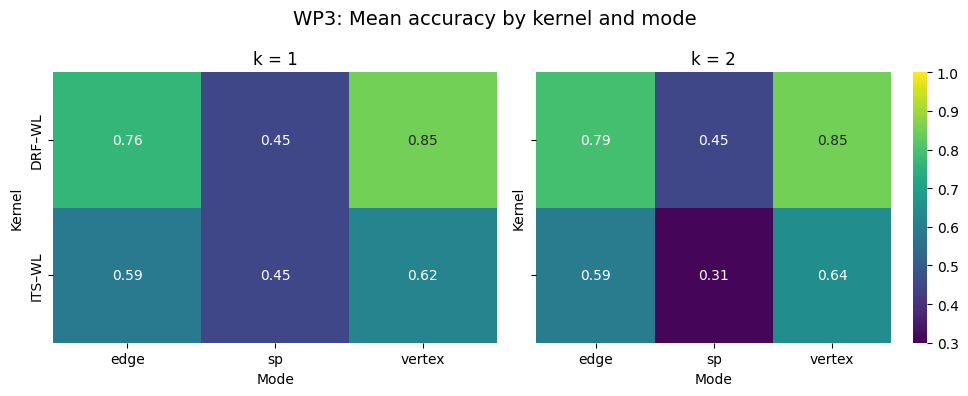

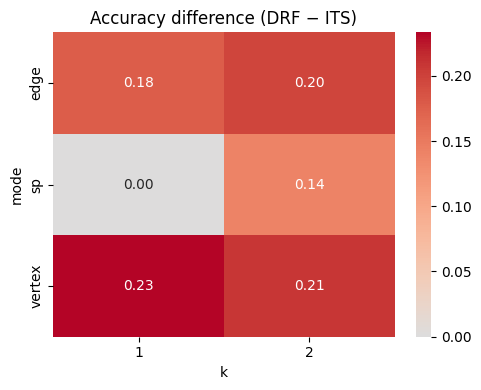

In [31]:
plot_heatmaps_by_k(df_results)
plot_difference_heatmap(df_results)


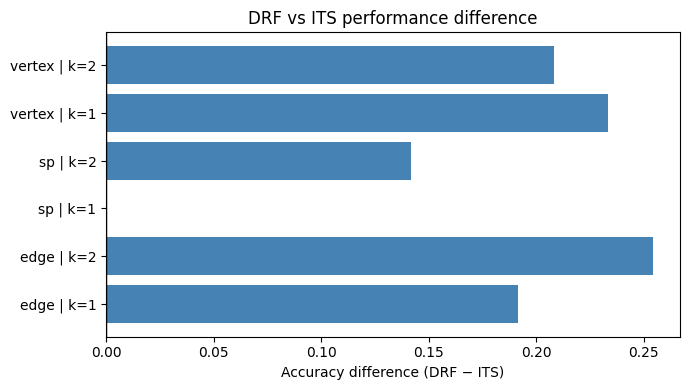

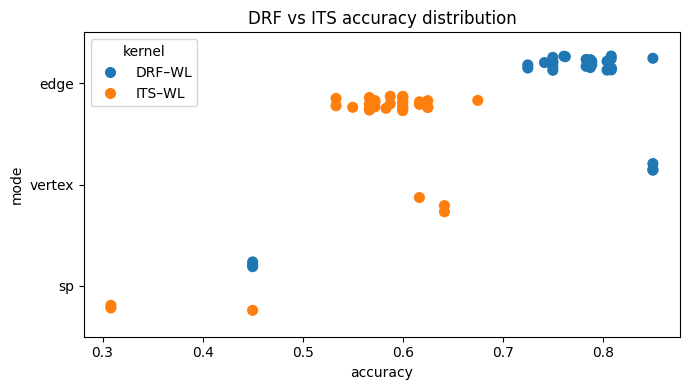

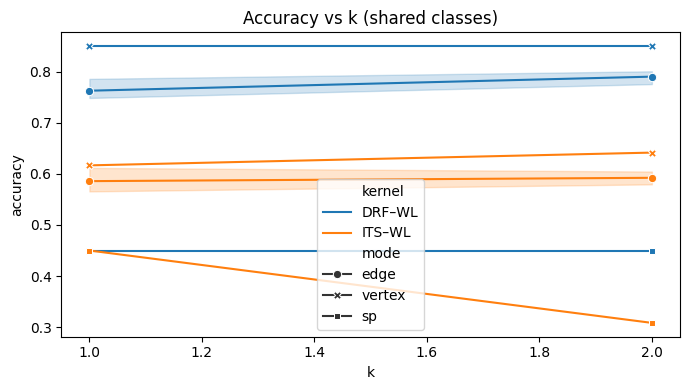

In [32]:
# 1) Hauptvergleich
plot_drf_minus_its_bar(df_results)

# 2) Stabilität / Verteilung
plot_drf_vs_its_dots(df_results)

# 3) Einfluss von k
plot_accuracy_by_k(df_results)